# Preparing data and a linear model

In [1]:
# volatile stock => prices move a lot
# adjusted close price e.g. stock split
# predict percent changes, not prices

Explore the data with some EDA
First, let's explore the data. Any time we begin a machine learning (ML) project, we need to first do some exploratory data analysis (EDA) to familiarize ourselves with the data. This includes things like:

raw data plots<br>
histograms<br>
and more…

I typically begin with raw data plots and histograms. This allows us to understand our data's distributions. If it's a normal distribution, we can use things like parametric statistics.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
lng_df = pd.read_csv('C:/Users/Jacob/Desktop/Online Course/Machine Learning for Finance in Python/LNG.csv')

In [4]:
lng_df = lng_df.iloc[5548:6048]
lng_df = lng_df.set_index('Date')

In [5]:
spy_df = pd.read_csv('C:/Users/Jacob/Desktop/Online Course/Machine Learning for Finance in Python/SPY.csv')

In [6]:
spy_df = spy_df.iloc[5845:6345]
spy_df = spy_df.set_index('Date')

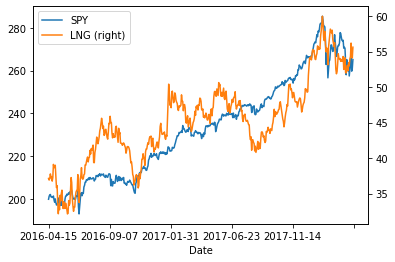

In [7]:
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()  # show the plot

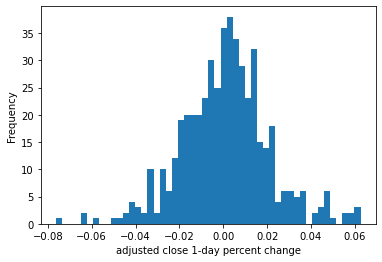

In [8]:
lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

Correlations

Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

In [9]:
# Create 5 days % changes in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5) #shift up
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df.head(15)

#look at the 5d_future_close column,(38.88-37.4)/37.4 = 0.039572

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct
Date,,,,
2016-04-15,37.13,4293775.0,37.40,NaN
2016-04-18,36.90,3445852.0,36.75,NaN
2016-04-19,37.12,3748050.0,37.25,NaN
2016-04-20,37.77,2470384.0,39.11,NaN
2016-04-21,37.21,2043988.0,38.62,NaN
2016-04-22,37.40,2786757.0,38.88,0.039572
2016-04-25,36.75,1830397.0,38.99,0.060952
2016-04-26,37.25,2384800.0,37.37,0.003221
2016-04-27,39.11,2559759.0,35.85,-0.083355


In [10]:
# Create 5-day % changes of Adj_Close 
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)
lng_df.head(8)

##look at the Adj_Close column,(37.4-37.13)/37.13 = 0.007272

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct
Date,,,,,
2016-04-15,37.13,4293775.0,37.40,NaN,NaN
2016-04-18,36.90,3445852.0,36.75,NaN,NaN
2016-04-19,37.12,3748050.0,37.25,NaN,NaN
2016-04-20,37.77,2470384.0,39.11,NaN,NaN
2016-04-21,37.21,2043988.0,38.62,NaN,NaN
2016-04-22,37.40,2786757.0,38.88,0.039572,0.007272
2016-04-25,36.75,1830397.0,38.99,0.060952,-0.004065
2016-04-26,37.25,2384800.0,37.37,0.003221,0.003502


                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.164861
5d_close_future_pct     -0.164861             1.000000


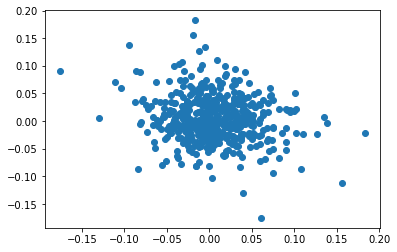

In [11]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()
#We can see the 5-day change is slightly negatively correlated to the change in the last 5 days
#an example of overall mean reversion

RSI:<br> https://www.cmoney.tw/learn/course/technicals/topic/490  <br>
Golden Cross: https://service.hket.com/knowledge/2132312/%E4%BD%95%E8%AC%82%E9%BB%83%E9%87%91%E4%BA%A4%E5%8F%89%EF%BC%9F

### Create moving average and RSI features

talib cannot be download through anaconda<br>
https://blog.csdn.net/u010671948/article/details/79714647<br>
https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib

In [12]:
import talib

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close(Normalize)
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [13]:
# Drop all na values
lng_df = lng_df.dropna()
lng_df

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
Date,,,,,,,,,,,,,
2017-01-31,47.65,2137394.0,47.81,0.003358,0.043812,0.950697,62.968946,0.918657,60.655749,0.895731,57.951677,0.839267,53.695377
2017-02-01,47.10,2051631.0,48.01,0.019321,-0.023429,0.967486,60.156019,0.932427,59.159791,0.910110,57.041713,0.850150,53.487663
2017-02-02,49.33,3081369.0,49.19,-0.002838,-0.021618,0.932220,66.659314,0.895486,62.988478,0.873379,59.662227,0.812956,54.209475
2017-02-03,49.43,4158130.0,48.93,-0.010115,0.007336,0.938976,66.920059,0.899461,63.148741,0.875497,59.774509,0.812490,54.241479
2017-02-06,48.50,2090909.0,48.14,-0.007423,0.022129,0.964080,62.059184,0.921608,60.623276,0.895860,58.236185,0.829234,53.889442
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,53.06,1907271.0,54.30,0.023370,0.001510,1.004725,46.112898,1.026354,48.423080,1.041368,50.601497,0.922859,52.446487
2018-03-28,52.30,1272452.0,56.21,0.074761,-0.033986,1.017058,42.796606,1.038018,46.788195,1.055159,49.525314,0.936544,52.142361
2018-03-29,53.45,2756953.0,54.36,0.017025,0.027489,0.994387,48.797185,1.012735,49.459257,1.031622,51.130119,0.916875,52.560707


In [14]:
# Create features and targets

# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names] #first three columns removed
targets = lng_df['5d_close_future_pct']
features.shape, targets.shape

((295, 9), (295,))

In [15]:
# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]
feat_targ_df.shape

(295, 10)

In [16]:
# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000     -0.047183  0.096373 -0.068888   
5d_close_pct                   -0.047183      1.000000 -0.827699  0.683973   
ma14                            0.096373     -0.827699  1.000000 -0.877566   
rsi14                          -0.068888      0.683973 -0.877566  1.000000   
ma30                            0.102744     -0.609573  0.848778 -0.964795   
rsi30                          -0.106279      0.518748 -0.713427  0.935711   
ma50                            0.113444     -0.475081  0.692689 -0.916540   
rsi50                          -0.138946      0.426045 -0.601849  0.845788   
ma200                           0.230860     -0.220690  0.346457 -0.551087   
rsi200                         -0.221029      0.284021 -0.416221  0.639057   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct  0.102744 -0.106279  0.113444 -0.138946  0.23086

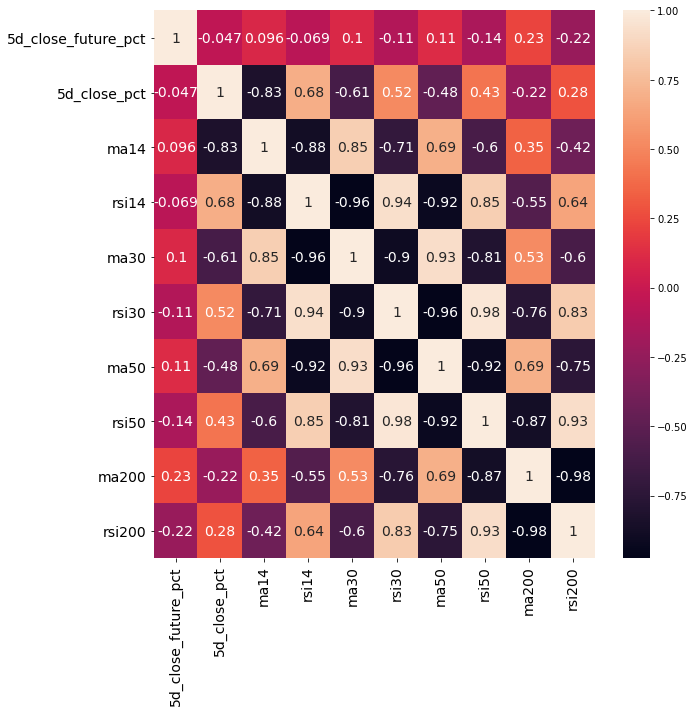

In [17]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))

# Plot heatmap of correlation matrix
sns.heatmap(corr, annot= True, annot_kws = {"size": 14})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

sklearn randomly shuffle the data for train and test set
not used in time series model

In [18]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(295, 10) (250, 10) (45, 10)


In [19]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.273
Model:                             OLS   Adj. R-squared:                  0.246
Method:                  Least Squares   F-statistic:                     10.01
Date:                 Wed, 06 Jan 2021   Prob (F-statistic):           4.92e-13
Time:                         21:02:02   Log-Likelihood:                 536.49
No. Observations:                  250   AIC:                            -1053.
Df Residuals:                      240   BIC:                            -1018.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8197      1.169    

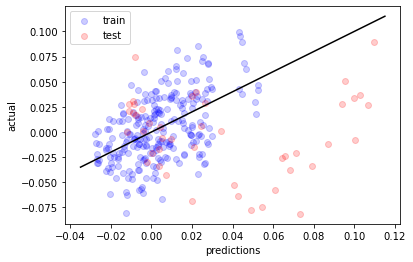

In [20]:
import numpy as np

# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

# Tree methods

limitation of linear model: need explicitly add feature interaction terms

decision tree based model like random forest and gradient boosting take care of this <br>
Volumes are essentially uncorrelated with price movement <br>
volume.pct_change may give hint for the price movement

Feature engineering from volume

We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

To incorporate more information that may interact with other features, we can add in weakly-correlated features. First we will add volume data, which we have in the lng_df as the Adj_Volume column.

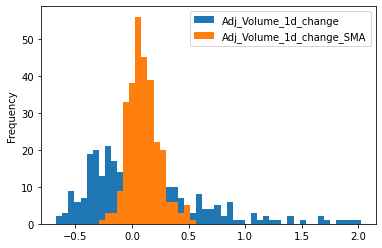

In [21]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values,
                        timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

#We can see the moving average of volume changes has a much smaller range than the raw data.

In [22]:
lng_df.index=pd.to_datetime(lng_df.index)

Create day-of-week features

We can engineer datetime features to add even more information for our non-linear models. Most financial data has datetimes, which have lots of information in them -- year, month, day, and sometimes hour, minute, and second. But we can also get the day of the week, and things like the quarter of the year, or the elapsed time since some event (e.g. earnings reports).

We are only going to get the day of the week here, since our dataset doesn't go back very far in time. The dayofweek property from the pandas datetime index will help us get the day of the week. Then we will dummy dayofweek with pandas' get_dummies(). This creates columns for each day of the week with binary values (0 or 1). We drop the first column because it can be inferred from the others.

In [23]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True) #e.g. originally 5 dummies, but 4 dummies are enough
days_of_week
#weekday_1=Tuesday
#weekday_4=Friday

,weekday_1,weekday_2,weekday_3,weekday_4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,0,0,0,0
...,...,...,...,...
290,1,0,0,0
291,0,1,0,0
292,0,0,1,0
293,0,0,0,0


In [24]:
# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
lng_df.head()

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,
2017-02-07,47.81,2522644.0,47.88,0.001464,0.003358,0.985448,58.654992,0.939476,58.817869,0.911801,57.123212,0.842290,53.629901,0.206482,0.104112,1,0,0,0
2017-02-08,48.01,1521339.0,47.69,-0.006665,0.019321,0.989333,59.351015,0.940047,59.182360,0.911289,57.364214,0.839954,53.694867,-0.396927,0.032752,0,1,0,0
2017-02-09,49.19,1717838.0,46.84,-0.047774,-0.002838,0.974211,63.278848,0.922383,61.274321,0.893214,58.759765,0.821018,54.076387,0.129162,-0.041798,0,0,1,0
2017-02-10,48.93,1747989.0,46.71,-0.045371,-0.010115,0.987957,61.860468,0.931821,60.566775,0.902031,58.330493,0.826385,53.977901,0.017552,-0.108177,0,0,0,1
2017-02-13,48.14,2321977.0,47.36,-0.016203,-0.007423,1.007864,57.633333,0.951371,58.445466,0.919859,57.038536,0.840935,53.679362,0.328370,0.056928,0,0,0,0


In [25]:
features

,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
Date,,,,,,,,,
2017-01-31,0.043812,0.950697,62.968946,0.918657,60.655749,0.895731,57.951677,0.839267,53.695377
2017-02-01,-0.023429,0.967486,60.156019,0.932427,59.159791,0.910110,57.041713,0.850150,53.487663
2017-02-02,-0.021618,0.932220,66.659314,0.895486,62.988478,0.873379,59.662227,0.812956,54.209475
2017-02-03,0.007336,0.938976,66.920059,0.899461,63.148741,0.875497,59.774509,0.812490,54.241479
2017-02-06,0.022129,0.964080,62.059184,0.921608,60.623276,0.895860,58.236185,0.829234,53.889442
...,...,...,...,...,...,...,...,...,...
2018-03-27,0.001510,1.004725,46.112898,1.026354,48.423080,1.041368,50.601497,0.922859,52.446487
2018-03-28,-0.033986,1.017058,42.796606,1.038018,46.788195,1.055159,49.525314,0.936544,52.142361
2018-03-29,0.027489,0.994387,48.797185,1.012735,49.459257,1.031622,51.130119,0.916875,52.560707


In [26]:
new_features

['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']

In [27]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

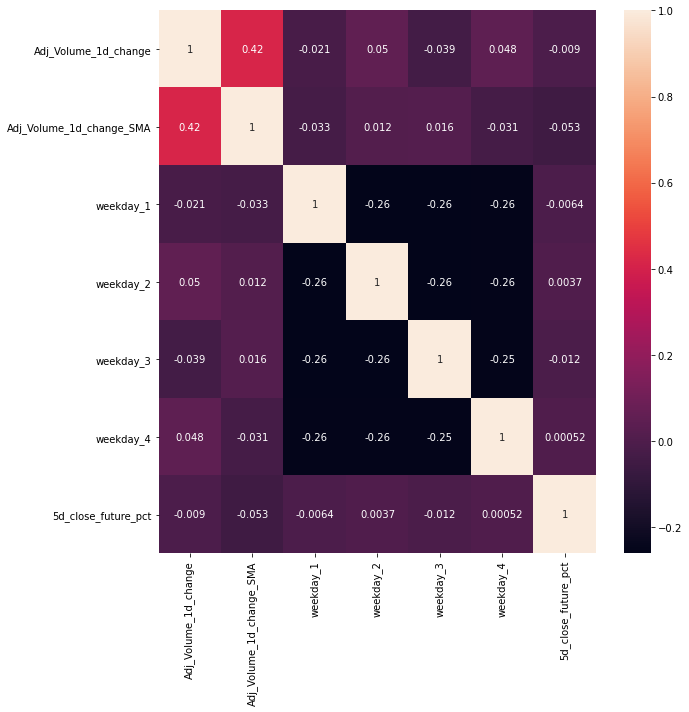

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

#Even though the correlations are weak, they may improve our predictions via interactions with other features.

In [29]:
lng_df.head(8)

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,
2017-02-07,47.81,2522644.0,47.88,0.001464,0.003358,0.985448,58.654992,0.939476,58.817869,0.911801,57.123212,0.842290,53.629901,0.206482,0.104112,1,0,0,0
2017-02-08,48.01,1521339.0,47.69,-0.006665,0.019321,0.989333,59.351015,0.940047,59.182360,0.911289,57.364214,0.839954,53.694867,-0.396927,0.032752,0,1,0,0
2017-02-09,49.19,1717838.0,46.84,-0.047774,-0.002838,0.974211,63.278848,0.922383,61.274321,0.893214,58.759765,0.821018,54.076387,0.129162,-0.041798,0,0,1,0
2017-02-10,48.93,1747989.0,46.71,-0.045371,-0.010115,0.987957,61.860468,0.931821,60.566775,0.902031,58.330493,0.826385,53.977901,0.017552,-0.108177,0,0,0,1
2017-02-13,48.14,2321977.0,47.36,-0.016203,-0.007423,1.007864,57.633333,0.951371,58.445466,0.919859,57.038536,0.840935,53.679362,0.328370,0.056928,0,0,0,0
2017-02-14,47.88,1554408.0,47.22,-0.013784,0.001464,1.012815,56.270493,0.961028,57.756748,0.927607,56.617400,0.846441,53.581340,-0.330567,-0.050482,1,0,0,0
2017-02-15,47.69,1259163.0,47.35,-0.007129,-0.006665,1.012761,55.242456,0.968589,57.246777,0.933995,56.307391,0.850726,53.509576,-0.189940,-0.009085,0,1,0,0
2017-02-16,46.84,1604430.0,47.46,0.013237,-0.047774,1.027739,50.773413,0.988898,54.999334,0.953096,54.934277,0.867174,53.189276,0.274204,0.019924,0,0,1,0


### Decision Tree

In [30]:
new_features

['Adj_Volume_1d_change',
 'Adj_Volume_1d_change_SMA',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4']

In [31]:
train_features

,const,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
Date,,,,,,,,,,
2017-01-31,1.0,0.043812,0.950697,62.968946,0.918657,60.655749,0.895731,57.951677,0.839267,53.695377
2017-02-01,1.0,-0.023429,0.967486,60.156019,0.932427,59.159791,0.910110,57.041713,0.850150,53.487663
2017-02-02,1.0,-0.021618,0.932220,66.659314,0.895486,62.988478,0.873379,59.662227,0.812956,54.209475
2017-02-03,1.0,0.007336,0.938976,66.920059,0.899461,63.148741,0.875497,59.774509,0.812490,54.241479
2017-02-06,1.0,0.022129,0.964080,62.059184,0.921608,60.623276,0.895860,58.236185,0.829234,53.889442
...,...,...,...,...,...,...,...,...,...,...
2018-01-22,1.0,0.012059,0.992134,67.454995,0.948517,65.158943,0.918783,61.731725,0.853612,54.558480
2018-01-23,1.0,0.024189,0.964486,74.935143,0.925169,68.970930,0.892687,64.237104,0.828025,55.225121
2018-01-24,1.0,0.039871,0.955403,77.285688,0.919390,70.372876,0.884135,65.208812,0.818346,55.499429


In [32]:
train_targets

Date
2017-01-31    0.003358
2017-02-01    0.019321
2017-02-02   -0.002838
2017-02-03   -0.010115
2017-02-06   -0.007423
                ...   
2018-01-22    0.065896
2018-01-23   -0.002974
2018-01-24   -0.023143
2018-01-25   -0.015819
2018-01-26   -0.066344
Name: 5d_close_future_pct, Length: 250, dtype: float64

In [33]:
train_features=lng_df.iloc[0:250:,4:19]
train_targets=lng_df['5d_close_future_pct'][0:250]

In [34]:
train_features

,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,
2017-02-07,0.003358,0.985448,58.654992,0.939476,58.817869,0.911801,57.123212,0.842290,53.629901,0.206482,0.104112,1,0,0,0
2017-02-08,0.019321,0.989333,59.351015,0.940047,59.182360,0.911289,57.364214,0.839954,53.694867,-0.396927,0.032752,0,1,0,0
2017-02-09,-0.002838,0.974211,63.278848,0.922383,61.274321,0.893214,58.759765,0.821018,54.076387,0.129162,-0.041798,0,0,1,0
2017-02-10,-0.010115,0.987957,61.860468,0.931821,60.566775,0.902031,58.330493,0.826385,53.977901,0.017552,-0.108177,0,0,0,1
2017-02-13,-0.007423,1.007864,57.633333,0.951371,58.445466,0.919859,57.038536,0.840935,53.679362,0.328370,0.056928,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-29,0.065896,0.952768,73.932511,0.920715,69.930434,0.877324,65.512999,0.805336,55.824151,-0.369715,0.137488,0,0,0,0
2018-01-30,-0.002974,0.990863,59.561115,0.958051,62.461928,0.911620,61.049948,0.835196,54.897148,0.573137,0.031643,1,0,0,0
2018-01-31,-0.023143,1.001781,57.055799,0.969437,61.047206,0.921135,60.172560,0.842414,54.705641,-0.184346,-0.084660,0,1,0,0


In [35]:
test_features=lng_df.iloc[250:,4:19]
test_targets=lng_df['5d_close_future_pct'][250:]

In [36]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor() 
#no arguments here, so the model will keep splitting the data until each leaf has 1 sample in it

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
0.20603995885939075


In [37]:
# Loop through a few different max depths and check the performance
for d in [3,5,10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))   # R^2
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.22271665161093213
-0.024758926488604338 

max_depth= 5
0.4624251057913127
0.18954190987818953 

max_depth= 10
0.8474394961841436
0.25554681959960257 



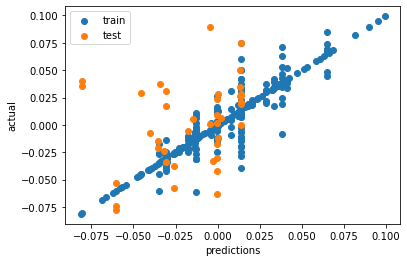

In [38]:
# Use the best max_depth of 10 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()
#The predictions group into lines because our depth is limited.

### Random Forest

Random forest: collection of decision tree, boostraping of training data for each trained tree, sample a number of features(not all) at each split

Cater for bias and variance

can be used for classification or regression

In [39]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9002117861763419
0.1498014002790582


In [40]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}

#n_estimators: no. of trees in the forest(default=10)
#max_depth: level of tree
#max_features: no. of features that are randomly chosen, default=sqrt(total no. of features)


test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.0867777903404362 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


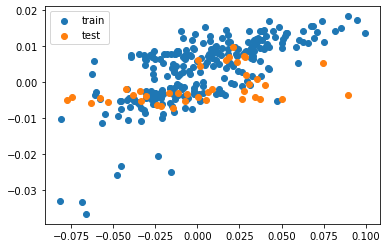

In [41]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

### Feature importances and gradient boosting

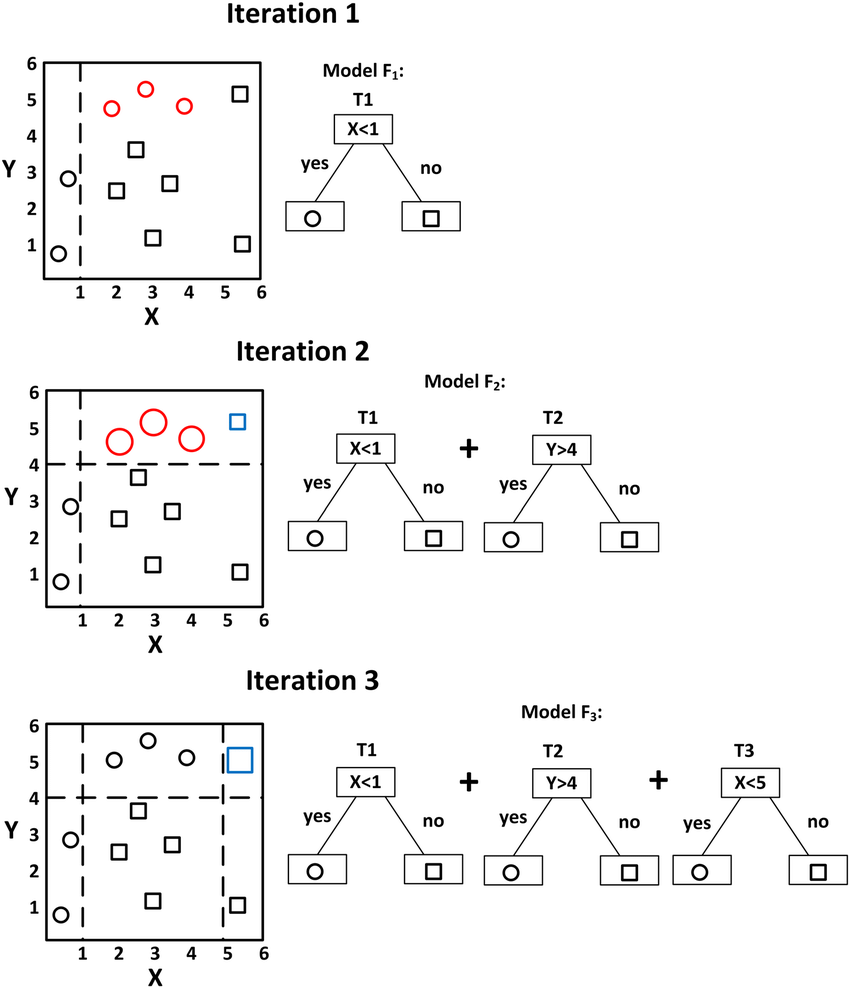

In [42]:
#gb
Image(filename= "C:/Users/Jacob/Desktop/Online Course/Machine Learning for Finance in Python/gbtree.png", width=400, height=400)

In [43]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_
importances

array([0.04843779, 0.0637931 , 0.09340973, 0.04817701, 0.0886375 ,
       0.10753602, 0.09750875, 0.17881831, 0.15546803, 0.0336999 ,
       0.07939991, 0.00156859, 0.00173498, 0.00119993, 0.00061045])

In [44]:
# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index

array([ 7,  8,  5,  6,  2,  4, 10,  1,  0,  3,  9, 12, 11, 13, 14],
      dtype=int64)

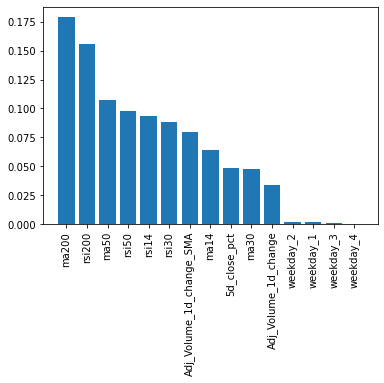

In [45]:
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

#it looks like the days of the week should be thrown out.

### Gradient boosting model

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features,train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

#no free lunch theorem
#testset R^2 of random forest: 0.08
#testset R^2 of gb: 0.07
#change the max_feature from 4 to 5, testset R^2 increases to 0.1

0.4195827151241869
0.07206342344312267


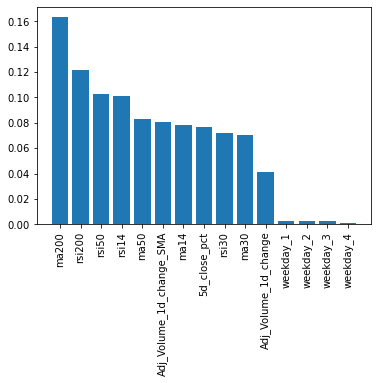

In [47]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(train_features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

### Standardizing data

In [48]:
# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

In [49]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

In [50]:
train_features.iloc[:, 2] #rsi14

Date
2017-02-07    58.654992
2017-02-08    59.351015
2017-02-09    63.278848
2017-02-10    61.860468
2017-02-13    57.633333
                ...    
2018-01-29    73.932511
2018-01-30    59.561115
2018-01-31    57.055799
2018-02-01    62.228564
2018-02-02    52.531295
Name: rsi14, Length: 250, dtype: float64

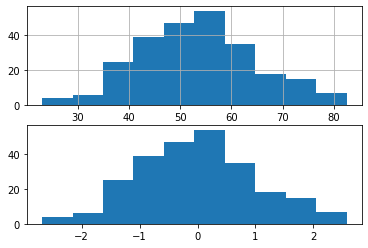

In [51]:
# Plot histograms of the 14-day SMA RSI
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0]) #before scaling
ax[1].hist(scaled_train_features[:, 2]) #after scaling
plt.show()

KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.

sklearn's scale() will standardize data, which sets the mean to 0 and standard deviation to 1. <br>
Alternatively, we can use StandardScaler with fit_transform() on the training data, and fit() on the test data

In [52]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

# n=9 is the best on testset, with R^2 = 0.04

n_neighbors = 2
train, test scores
0.7126091842751092
-0.3721165334141803

n_neighbors = 3
train, test scores
0.6283381268597019
-0.11708276643909721

n_neighbors = 4
train, test scores
0.5885146922217506
-0.0939855003819654

n_neighbors = 5
train, test scores
0.5587938965124
-0.08432904352743598

n_neighbors = 6
train, test scores
0.5196827710713887
-0.03298484006201341

n_neighbors = 7
train, test scores
0.4811043558189565
-0.016633437749496327

n_neighbors = 8
train, test scores
0.4360251582823318
0.010082235026292463

n_neighbors = 9
train, test scores
0.40268048053525496
0.04352977279015735

n_neighbors = 10
train, test scores
0.3564060380971389
0.0019985010949350457

n_neighbors = 11
train, test scores
0.312516804608719
-0.0058104513736867425

n_neighbors = 12
train, test scores
0.2695927552581554
0.03171248101060464



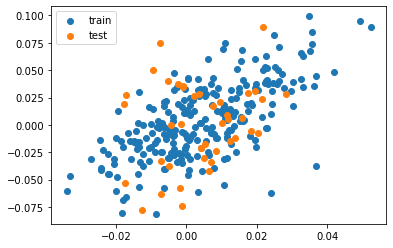

In [53]:
# Create the model with the best-performing n_neighbors of 9
knn = KNeighborsRegressor(9)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

### Neural Networks

In [54]:
#a 3-layer net that takes inputs and predicts a single value.
#2 hidder layers and a output layer

from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0826
Epoch 2/25
8/8 [==============================] - 0s 998us/step - loss: 0.0132
Epoch 3/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 4/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 5/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 6/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 7/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 8/25
8/8 [==============================] - 0s 997us/step - loss: 0.0017
Epoch 9/25
8/8 [==============================] - 0s 855us/step - loss: 0.0016
Epoch 10/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 11/25
8/8 [==============================] - 0s 997us/step - loss: 0.0013
Epoch 12/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 13/25
8/8 [==============================] - 0s 1ms/step - 

In [55]:
history.history['loss']

[0.05281559005379677,
 0.01332768239080906,
 0.010051803663372993,
 0.004836333449929953,
 0.0034666850697249174,
 0.0028320683632045984,
 0.0021596408914774656,
 0.0017953471979126334,
 0.001579301431775093,
 0.0014139905106276274,
 0.001311806496232748,
 0.0012079565785825253,
 0.0011335195740684867,
 0.0010694877710193396,
 0.0010009953984990716,
 0.0009385949233546853,
 0.0008606078336015344,
 0.000830366974696517,
 0.0007710017962381244,
 0.0007565561099909246,
 0.000703516649082303,
 0.0006687403074465692,
 0.000649893656373024,
 0.0006326987640932202,
 0.0005691445549018681]

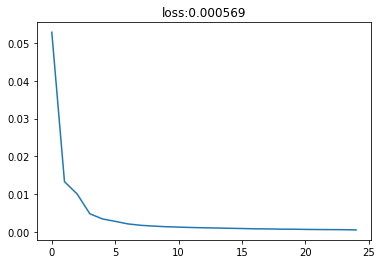

In [56]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.5243759737015664
-1.5213981245105304


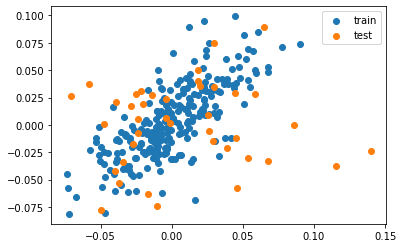

In [57]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()
#poor result as loss function is still not customized

we've used the mean squared error as a loss function.<br>
A custom loss function can help improve our model's performance in specific ways we choose. For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our net learn to at least predict price movements in the correct direction.

In [58]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_predicted):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_predicted, 0), \
                     penalty * tf.square(y_true - y_predicted), \
                     tf.square(y_true - y_predicted))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x000001756F7AE0D0>


Epoch 1/25
8/8 [==============================] - 1s 1ms/step - loss: 6.5503
Epoch 2/25
8/8 [==============================] - 0s 1ms/step - loss: 2.1599
Epoch 3/25
8/8 [==============================] - 0s 997us/step - loss: 0.7285
Epoch 4/25
8/8 [==============================] - 0s 1ms/step - loss: 0.4820
Epoch 5/25
8/8 [==============================] - 0s 1ms/step - loss: 0.3203
Epoch 6/25
8/8 [==============================] - 0s 1ms/step - loss: 0.3039
Epoch 7/25
8/8 [==============================] - 0s 997us/step - loss: 0.1817
Epoch 8/25
8/8 [==============================] - 0s 1ms/step - loss: 0.1802
Epoch 9/25
8/8 [==============================] - 0s 1ms/step - loss: 0.1206
Epoch 10/25
8/8 [==============================] - 0s 2ms/step - loss: 0.1176
Epoch 11/25
8/8 [==============================] - 0s 1ms/step - loss: 0.1134
Epoch 12/25
8/8 [==============================] - 0s 997us/step - loss: 0.0733
Epoch 13/25
8/8 [==============================] - 0s 1ms/step - lo

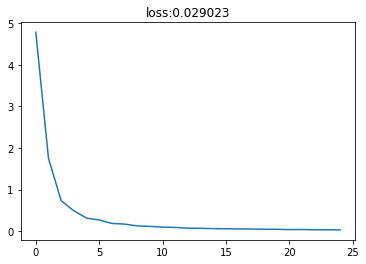

In [59]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

-0.5234768272999433
-1.4684138286275892


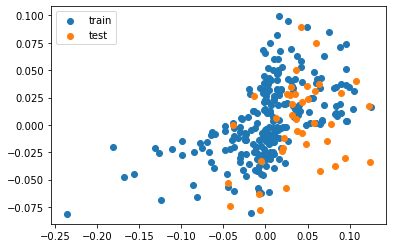

In [60]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()

#The train set actual vs predictions shape has changed to be a bow-tie.

### Addressing Overfitting

Epoch 1/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0944
Epoch 2/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0620
Epoch 3/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0338
Epoch 4/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0318
Epoch 5/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 6/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 7/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 8/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 9/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 10/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 11/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 12/25
8/8 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 13/25
8/8 [==============================] - 0s 1ms/step - loss: 0.

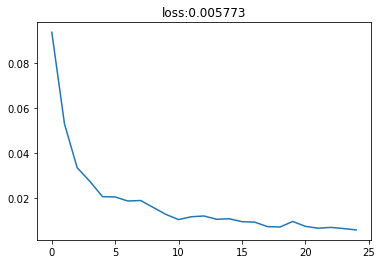

In [61]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2)) #since the NN is not large, so drop 20% only
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

This randomly drops some neurons during the training phase, which helps prevent the net from fitting noise in the training data.

In [62]:
train_preds = model_3.predict(scaled_train_features)
test_preds = model_3.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

#difference in R^2 is smaller with regularization

-0.6107883874911386
-0.1138729016485478


### Ensembling models

One approach to improve predictions from machine learning models is ensembling. A basic approach is to average the predictions from multiple models. A more complex approach is to feed predictions of models into another model, which makes final predictions. Both approaches usually improve our overall performance (as long as our individual models are good). Random forests are also using ensembling of many decision trees.

To ensemble our neural net predictions, we'll make predictions with the 3 models we just created -- the basic model, the model with the custom loss function, and the model with dropout. Then we'll combine the predictions , and average them.

In [63]:
# Make predictions from the 3 neural net models, with averaging predictions
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[ 0.01763919  0.03733211  0.0418369  -0.00043711  0.00780534]


0.3973082511622308
0.0006896747789567614


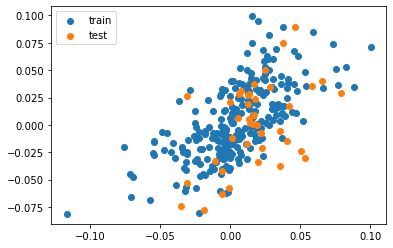

In [64]:
# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual 
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); 
plt.show()

# R^2 values are around the average of the 3 models we ensembled. 
# Notice the plot also looks like the bow-tie shape has been softened a bit.
# The bow-tie shape from the custom loss function model should still be a bit visible, 
#but the edges near x=0 should be softer.

# Modern portfolio theory
##### to find ideal investment portfolios by quantifying return and risk
##### return is the percentage change of asset, risk is measured via volatility using SD
#### decide a timeframe for rebalancing portfolio. i.e. when we will sell and buy stocks to match desired portfolio

In [65]:
lng_df = pd.read_csv('C:/Users/Jacob/Desktop/Online Course/Machine Learning for Finance in Python/LNG.csv')
spy_df = pd.read_csv('C:/Users/Jacob/Desktop/Online Course/Machine Learning for Finance in Python/SPY.csv')
smlv_df = pd.read_csv('C:/Users/Jacob/Desktop/Online Course/Machine Learning for Finance in Python/SMLV.csv')
lng_df = lng_df.set_index('Date')
spy_df = spy_df.set_index('Date')
smlv_df = smlv_df.set_index('Date')
lng_df.index=pd.to_datetime(lng_df.index)
spy_df.index=pd.to_datetime(spy_df.index)
smlv_df.index=pd.to_datetime(smlv_df.index)
lng_df.rename(columns={'Adj_Close':'LNG'},inplace=True)
spy_df.rename(columns={'Adj_Close':'SPY'},inplace=True)
smlv_df.rename(columns={'Adj_Close':'SMLV'},inplace=True)
lng_df=lng_df['LNG']
spy_df=spy_df['SPY']
smlv_df=smlv_df['SMLV']

First step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. Eventually we're going to get the best portfolios of each month based on the Sharpe ratio. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

In [66]:
# Join 3 stock dataframes together
full_df = pd.concat([lng_df, spy_df, smlv_df], axis=1).dropna()
full_df

,LNG,SPY,SMLV
Date,,,
2013-02-21,20.21,139.802535,49.482507
2013-02-22,20.99,141.168775,49.881225
2013-02-25,20.44,138.482768,49.440974
2013-02-26,21.15,139.430774,49.200082
2013-02-27,21.57,141.187368,49.424361
...,...,...,...
2018-04-10,55.63,265.150000,89.373200
2018-04-11,56.25,263.760000,89.101200
2018-04-12,56.20,265.930000,89.190000


In [67]:
# try the dataframe extracted from console!!!!
full_df = pd.read_csv('C:/Users/Jacob/Desktop/Online Course/Machine Learning for Finance in Python/full_df_from_console.txt',delim_whitespace=True,index_col='Date')
full_df.index=pd.to_datetime(full_df.index)

Calculate covariances for volatility

In MPT, we quantify risk via volatility. The math for calculating portfolio volatility is complex, and it requires daily returns covariances. We'll now loop through each month in the returns_monthly DataFrame, and calculate the covariance of the daily returns.

With pandas datetime indices, we can access the month and year with df.index.month and df.index.year. We'll use this to create a mask for returns_daily that gives us the daily returns for the current month and year in the loop. We then use the mask to subset the DataFrame like this: df[mask]. This gets entries in the returns_daily DataFrame which are in the current month and year in each cycle of the loop. Finally, we'll use pandas' .cov() method to get the covariance of daily returns.

In [68]:
# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()
monthly_df

,LNG,SPY,SMLV
Date,,,
2013-02-01,20.21,135.507156,49.482507
2013-03-01,21.16,137.029610,49.507427
2013-04-01,27.94,141.205073,51.366077
2013-05-01,27.89,143.222931,51.607545
2013-06-03,29.24,148.715503,52.648355
...,...,...,...
2018-01-01,54.70,267.699223,91.135411
2018-02-01,57.86,280.458188,90.787034
2018-03-01,51.88,266.633486,86.417392


In [69]:
# Calculate daily returns of stocks, for estimating volatility
returns_daily = full_df.pct_change()
returns_daily

,LNG,SPY,SMLV
Date,,,
2013-02-21,NaN,NaN,NaN
2013-02-22,0.038595,0.009773,0.008058
2013-02-25,-0.026203,-0.019027,-0.008826
2013-02-26,0.034736,0.006846,-0.004872
2013-02-27,0.019858,0.012598,0.004559
...,...,...,...
2018-05-24,-0.019087,-0.002049,0.002092
2018-05-25,0.007946,-0.002383,0.001719
2018-05-29,0.018501,-0.011501,0.001033


In [70]:
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

                 LNG       SPY      SMLV
Date                                    
2018-01-01  0.128300  0.021450 -0.010725
2018-02-01  0.057770  0.047662 -0.003823
2018-03-01 -0.103353 -0.049293 -0.048131
2018-04-02  0.021396 -0.034367  0.009406
2018-05-01  0.108322  0.029168  0.027469


In [71]:
len(returns_daily.index),len(returns_monthly.index)

(1329, 63)

In [72]:
returns_daily.index

DatetimeIndex(['2013-02-21', '2013-02-22', '2013-02-25', '2013-02-26',
               '2013-02-27', '2013-02-28', '2013-03-01', '2013-03-04',
               '2013-03-05', '2013-03-06',
               ...
               '2018-05-17', '2018-05-18', '2018-05-21', '2018-05-22',
               '2018-05-23', '2018-05-24', '2018-05-25', '2018-05-29',
               '2018-05-30', '2018-05-31'],
              dtype='datetime64[ns]', name='Date', length=1329, freq=None)

In [73]:
returns_monthly.index

DatetimeIndex(['2013-03-01', '2013-04-01', '2013-05-01', '2013-06-03',
               '2013-07-01', '2013-08-01', '2013-09-02', '2013-10-01',
               '2013-11-01', '2013-12-02', '2014-01-01', '2014-02-03',
               '2014-03-03', '2014-04-01', '2014-05-01', '2014-06-02',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-03', '2014-12-01', '2015-01-01', '2015-02-02',
               '2015-03-02', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01',
               '2015-11-02', '2015-12-01', '2016-01-01', '2016-02-01',
               '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01',
               '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03',
               '2016-11-01', '2016-12-01', '2017-01-02', '2017-02-01',
               '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01',
               '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02',
      

In [74]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index #1329
for i in returns_monthly.index:    #62
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year) #1329
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      SMLV
LNG   0.000376  0.000057  0.000060
SPY   0.000057  0.000043  0.000023
SMLV  0.000060  0.000023  0.000025


In [75]:
len(covariances)

63

In [76]:
rtd_idx.month

Int64Index([2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
            ...
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
           dtype='int64', name='Date', length=1329)

In [77]:
#covariances

In [78]:
mask,len(mask)

(array([False, False, False, ...,  True,  True,  True]), 1329)

In [79]:
len(rtd_idx.month == i.month)

1329

In [80]:
len(rtd_idx.year == i.year)

1329

In [81]:
returns_daily[mask]

,LNG,SPY,SMLV
Date,,,
2018-05-01,0.009801,0.001777,0.002868
2018-05-02,0.016857,-0.006717,0.000711
2018-05-03,-0.012391,-0.002204,-0.002330
2018-05-04,0.059003,0.012946,0.012376
2018-05-07,0.000480,0.003383,0.003623
2018-05-08,0.001760,0.000000,0.002897
2018-05-09,-0.003195,0.009666,0.002413
2018-05-10,-0.006891,0.009351,0.003829
2018-05-11,0.006777,0.003051,0.000251


In [82]:
#for i in returns_monthly.index:    #62
    # Mask daily returns for each month and year, and calculate covariance
#    print(rtd_idx.month)
#    print(i.month)
#    print(rtd_idx.year)
#    print(i.year)

Calculate portfolios

We'll now generate portfolios to find each month's best one. numpy's random.random() generates random numbers from a uniform distribution, then we normalize them so they sum to 1 using the /= operator. We use these weights to calculate returns and volatility. Returns are sums of weights times individual returns. Volatility is more complex, and involves the covariances of the different stocks.

Finally we'll store the values in dictionaries for later use, with months' dates as keys.

In this case, we will only generate 1000 portfolios for each date so the code will run faster, but in a real-world use-case you'd want to use more like 1000 to 5000 randomly-generated portfolios for a few stocks.

In [83]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()): #63
    cov = covariances[date]
    for portfolio in range(1000):  #1000
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.02150021 0.71835246 0.26014733]


Plot efficient frontier

We can finally plot the results of our MPT portfolios, which shows the "efficient frontier". This is a plot of the volatility vs the returns. This can help us visualize our risk-return possibilities for portfolios. The upper left boundary of the points is the best we can do (highest return for a given risk), and that is the efficient frontier.

To create this plot, we will use the latest date in our covariances dictionary. This has dates as keys, so we'll get the sorted keys using sorted() and .keys(), then get the last entry with Python indexing ([-1]). Lastly we'll use matplotlib to scatter variance vs returns and see the efficient frontier for the latest date in the data.

In [84]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  
date

Timestamp('2018-05-01 00:00:00', freq='BMS')

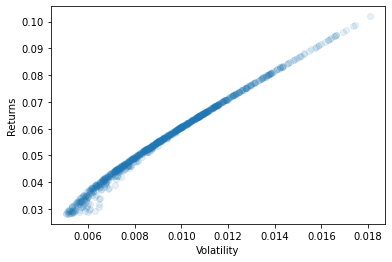

In [85]:
# Plot efficient frontier: maximal return given a certain risk
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()
#Often the efficient frontier will be a bullet shape, but if the returns are all positive then it may look like this.
#Each dot represents the return and standard deviation of a portfolio. 
#The blue line is the efficient frontier. It has all optimal portfolios we selected above. 
#Portfolios on the efficient frontier have maximum return for a given level of risk or, alternatively, 
#minimum risk for a given level of return. 
#Clearly, a rational investor will select a portfolio on the efficient frontier.

In [86]:
#portfolio_returns #63 days and 1000 returns in each day

In [87]:
len(portfolio_returns),len(portfolio_returns[date])

(63, 1000)

# Sharpe ratios

https://www.investopedia.com/terms/s/sharperatio.asp <br>
Portfolio weight with the highest sharpe ratio is the target

In [88]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys(): #63
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i]) #assuming risk free return = 0

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]]) #given a specific date, the best sharpe ratio of the portfolio

0.044606282370570044


In [89]:
#sharpe_ratio #63 days, 1000 sharpe ratio of each portfolio, total 63,000 ratios

In [90]:
#max_sharpe_idxs #len=63. For each day, the value is the index of the portfolio with the highest sharpe ratio 

In [91]:
date

Timestamp('2018-05-01 00:00:00', freq='BMS')

In [92]:
#portfolio_returns[date] #for 2018-05-01, 1000 portfolio returns

In [93]:
[max_sharpe_idxs[date]] #index of portfolio with the highest sharpe ratio

[965]

We have total 63 days, each day has the corresponding best sharpe ratio<br>
Therefore, there are 63 pairs of portfolio weights as the target<br>
We then use EMA as the features to predict for portfolio weights

We need to find the "ideal" portfolios for each date so we can use them as targets for machine learning. We'll loop through each date in portfolio_returns, then loop through the portfolios we generated with portfolio_returns[date]. We'll then calculate the Sharpe ratio, which is the return divided by volatility (assuming a no-risk return of 0).

We use enumerate() to loop through the returns for the current date (portfolio_returns[date]) and keep track of the index with i. Then we use the current date and current index to get the volatility of each portfolio with portfolio_volatility[date][i]. Finally, we get the index of the best Sharpe ratio for each date using np.argmax(). We'll use this index to get the ideal portfolio weights.

Calculate EWMAs<br>
We will now work towards creating some features to be able to predict our ideal portfolios. We will simply use the price movement as a feature for now. To do this we will create a daily exponentially-weighted moving average (EWMA), then resample that to the monthly timeframe. Finally, we'll shift the monthly moving average of price one month in the future, so we can use it as a feature for predicting future portfolios.

In [94]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean() #use 30 days for expoential calculation
ewma_daily

,LNG,SPY,SMLV
Date,,,
2013-02-21,NaN,NaN,NaN
2013-02-22,0.038595,0.009773,0.008058
2013-02-25,0.005116,-0.005107,-0.000666
2013-02-26,0.015655,-0.000854,-0.002162
2013-02-27,0.016813,0.002852,-0.000310
...,...,...,...
2018-05-24,0.001682,0.000892,0.001439
2018-05-25,0.002086,0.000680,0.001457
2018-05-29,0.003145,-0.000106,0.001430


In [95]:
# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()
ewma_monthly

,LNG,SPY,SMLV
Date,,,
2013-02-01,0.038595,0.009773,0.008058
2013-03-01,0.006870,0.002056,0.000039
2013-04-01,0.013170,0.001171,0.000966
2013-05-01,0.004331,0.000800,0.000598
2013-06-03,0.000820,0.000626,0.000044
...,...,...,...
2018-01-01,0.006037,0.001228,0.000157
2018-02-01,0.003666,0.001327,-0.000560
2018-03-01,-0.004304,-0.001003,-0.001670


In [96]:
ewma_monthly.shift(1) #shift downwards

,LNG,SPY,SMLV
Date,,,
2013-02-01,NaN,NaN,NaN
2013-03-01,0.038595,0.009773,0.008058
2013-04-01,0.006870,0.002056,0.000039
2013-05-01,0.013170,0.001171,0.000966
2013-06-03,0.004331,0.000800,0.000598
...,...,...,...
2018-01-01,0.001067,0.001504,0.001337
2018-02-01,0.006037,0.001228,0.000157
2018-03-01,0.003666,0.001327,-0.000560


In [97]:
# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

LNG    -0.000751
SPY    -0.002635
SMLV   -0.001181
Name: 2018-05-01 00:00:00, dtype: float64


In [98]:
ewma_monthly.iterrows()

<generator object DataFrame.iterrows at 0x000001757238A900>

In [99]:
#for date, ewma in ewma_monthly.iterrows():
#    print(date)

In [100]:
#for date, ewma in ewma_monthly.iterrows():
#    print(ewma)

In [101]:
#max_sharpe_idxs

In [102]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:]) #sum of each row is 1 as portfolio weight's sum is 1

[[8.79771181e-01 1.08953345e-01 1.12754739e-02]
 [2.69688076e-01 7.20717008e-01 9.59491651e-03]
 [1.73483338e-02 9.25617825e-01 5.70338412e-02]
 [4.89557144e-01 1.79332362e-04 5.10263523e-01]
 [2.07509152e-01 2.11629466e-01 5.80861382e-01]]


In [103]:
print(features[-5:])

[[ 0.00106691  0.001504    0.00133676]
 [ 0.00603657  0.00122841  0.00015714]
 [ 0.00366575  0.00132745 -0.0005603 ]
 [-0.00430363 -0.00100251 -0.00166981]
 [-0.00075088 -0.00263456 -0.0011812 ]]


In [104]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
date

Timestamp('2018-05-01 00:00:00', freq='BMS')

In [105]:
cur_returns = portfolio_returns[date] # 1000 portfolio returns on 2018-05-01
cur_volatility =  portfolio_volatility[date]
len(cur_returns)

1000

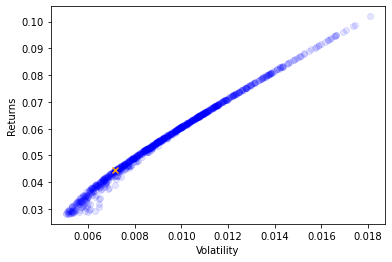

In [106]:
# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')

# Place an orange "X" on the point with the best Sharpe ratio
best_idx = max_sharpe_idxs[date]
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [107]:
#portfolio_weights #63days, 1000 portfolio

In [108]:
portfolio_weights[date][best_idx] # on 2018-05-01, the weight of portfolio with the best sharpe ratio
#here, no modelling yet

array([0.20750915, 0.21162947, 0.58086138])

### Modelling

In [109]:
features.shape # EMA

(63, 3)

In [110]:
targets.shape #portfolio weight

(63, 3)

In [111]:
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42) #no. of tree = 300
rfr.fit(train_features,train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8211764652078366
-0.5524635742995637


In [112]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)
test_predictions

array([[0.25678638, 0.46030099, 0.28291263],
       [0.51927385, 0.17501025, 0.30571591],
       [0.43173347, 0.3583033 , 0.20996323],
       [0.56618195, 0.32595409, 0.10786396],
       [0.51657408, 0.30461804, 0.17880789],
       [0.67645276, 0.22281795, 0.10072929],
       [0.26427013, 0.14265286, 0.59307701],
       [0.22165541, 0.31621341, 0.46213118],
       [0.06173225, 0.45380647, 0.48446128],
       [0.16931293, 0.56180765, 0.26887941]])

In [113]:
returns_monthly.iloc[train_size:]

,LNG,SPY,SMLV
Date,,,
2017-08-01,-0.081662,0.021097,0.003135
2017-09-01,-0.036628,0.002103,-0.014714
2017-10-02,0.049702,0.023120,0.059652
2017-11-01,0.037530,0.020490,-0.010705
2017-12-01,0.019558,0.027069,0.029058
2018-01-01,0.128300,0.021450,-0.010725
2018-02-01,0.057770,0.047662,-0.003823
2018-03-01,-0.103353,-0.049293,-0.048131
2018-04-02,0.021396,-0.034367,0.009406


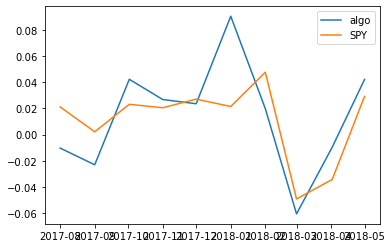

In [114]:
# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.show()
#is it doing as well or better than just buying the index, SPY?

In [115]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash  *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])
#We'll do this to see if our predictions are promising, despite the low R2 value.

algo returns: 0.14144633603994952
SPY returns: 0.10942393838171188


In [116]:
test_returns

Date
2017-08-01   -0.010372
2017-09-01   -0.023150
2017-10-02    0.042267
2017-11-01    0.026773
2017-12-01    0.023545
2018-01-01    0.090488
2018-02-01    0.019799
2018-03-01   -0.060739
2018-04-02   -0.009719
2018-05-01    0.042113
Freq: BMS, dtype: float64

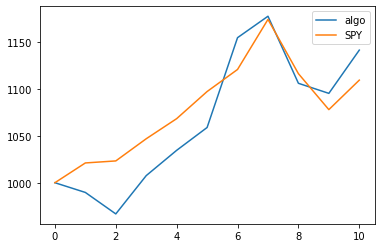

In [117]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()